In [25]:
%matplotlib inline
from itertools import groupby
from io import BytesIO

from IPython.display import display, Image

from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from models.unet import UNet
import torch
from data.data_loader import DataLoader
from data.test_generator_for_submission import FGVC6SubmissionSetGenerator

import random
from utils.image_utils import get_mask_images

FGVC6_DATA_SET_ROOT_PATH = '/run/media/twoaday/data-storag/data-sets/fgvc6-fashion/'
MODEL_PATH = '{0}unet_parser_cloud.pt'.format(FGVC6_DATA_SET_ROOT_PATH)
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
WIDTH, HEIGHT = 512, 512

In [2]:
sample_df = pd.read_csv('{0}sample_submission.csv'.format(FGVC6_DATA_SET_ROOT_PATH))

In [3]:
train_df = pd.read_csv('{0}train.csv'.format(FGVC6_DATA_SET_ROOT_PATH))

In [4]:
data_loader = DataLoader()
num_classes = data_loader.get_num_of_classes() + 1
submission_data_generator = FGVC6SubmissionSetGenerator(sample_df, num_classes, WIDTH, HEIGHT)

2019-05-19 17:06:21,260 : INFO : Loading label descriptions from: 
 {'year': 2019, 'version': '1.0', 'description': 'The 2019 FGVC^6 iMaterialist Competition - Fashion track dataset.', 'contributor': 'iMaterialist Fashion Competition group', 'url': 'https://github.com/visipedia/imat_comp', 'date_created': '2019-04-19 12:38:27.493919'}


In [5]:
model = UNet(3, num_classes).to(DEVICE)

In [6]:
model.load_state_dict(torch.load(MODEL_PATH))

/usr/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
/usr/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


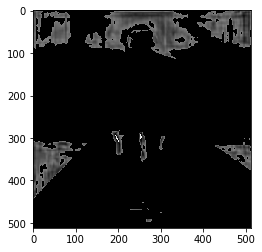

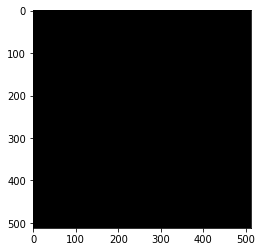

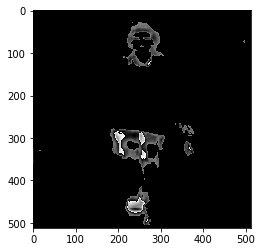

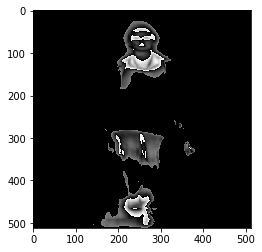

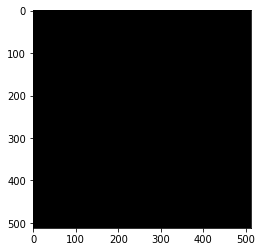

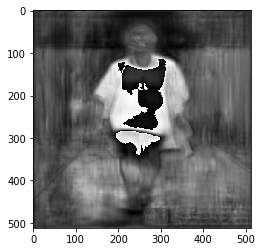

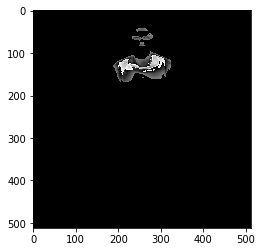

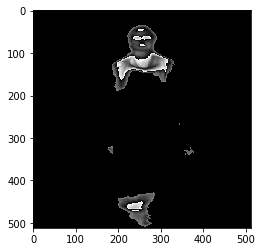

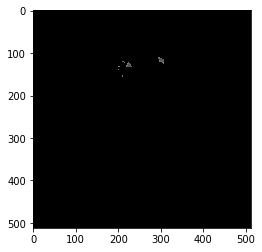

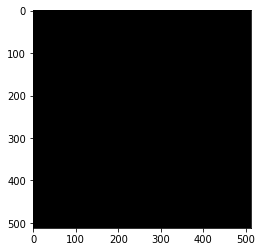

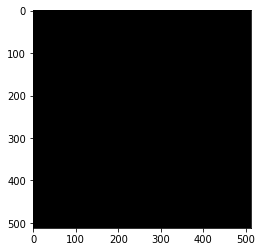

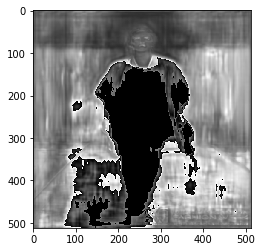

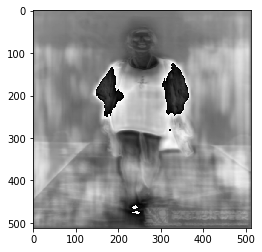

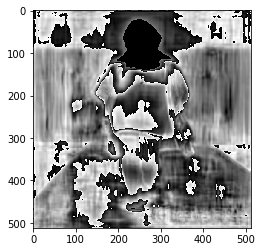

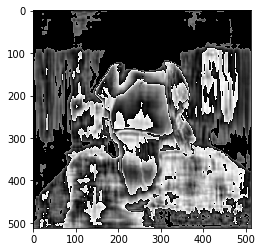

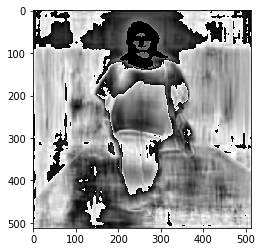

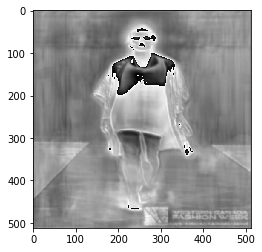

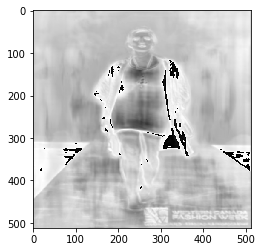

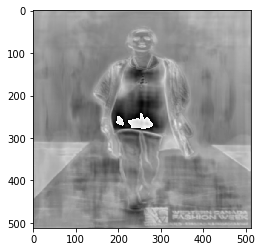

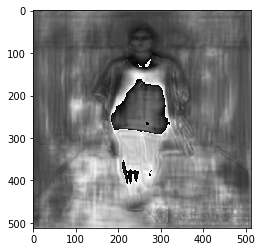

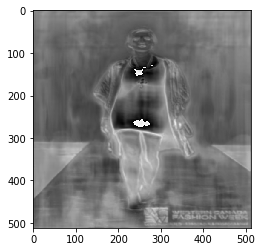

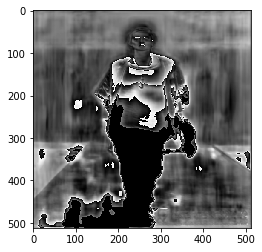

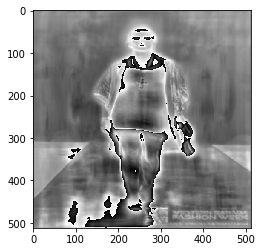

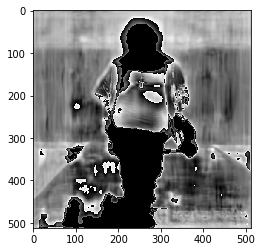

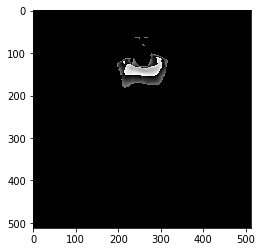

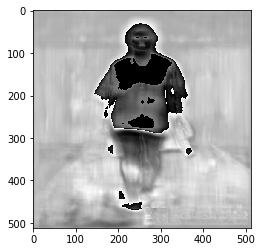

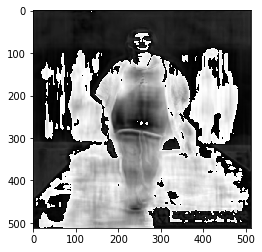

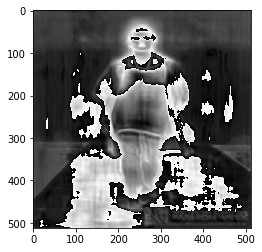

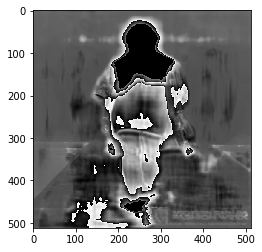

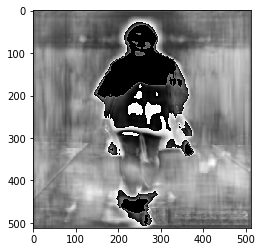

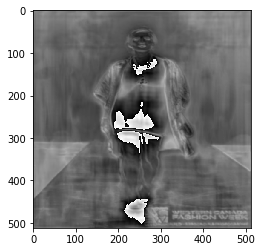

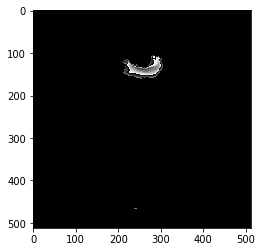

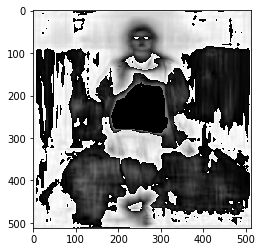

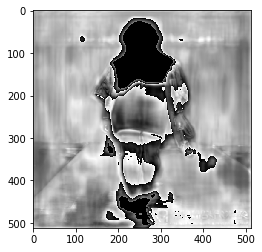

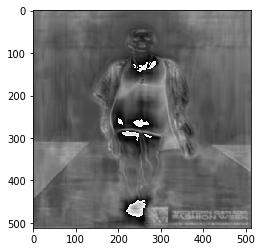

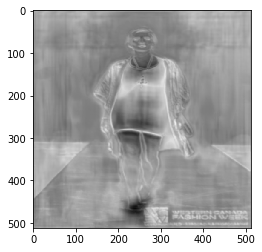

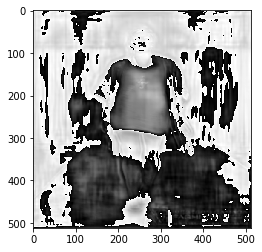

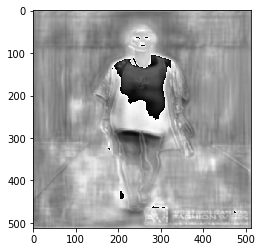

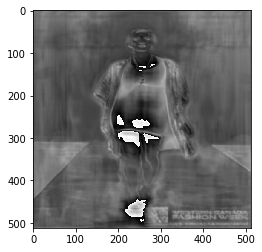

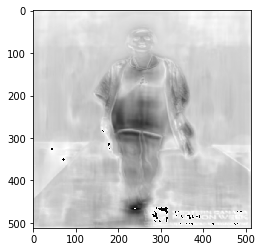

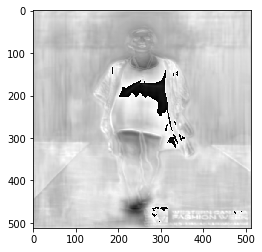

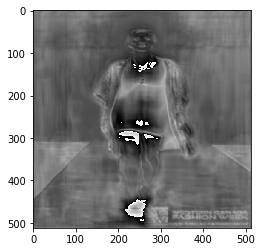

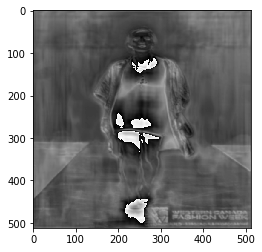

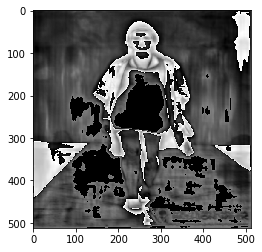

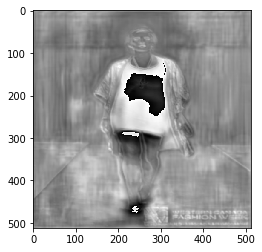

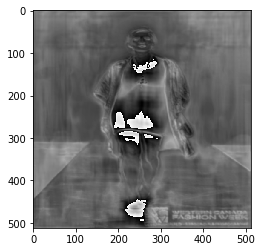

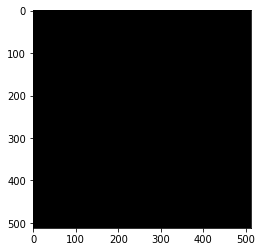

In [42]:
sample = train_df.sample(1)
img_name = sample.ImageId.values[0]
img_width, img_height = sample.Width.values[0], sample.Height.values[0] 
img = cv2.imread('{0}train_images/{1}'.format(FGVC6_DATA_SET_ROOT_PATH, img_name))
img = cv2.resize(img, (WIDTH, HEIGHT), interpolation=cv2.INTER_AREA)
# HWC -> CHW
img = img.transpose((2, 0, 1))
img = np.asarray([img], dtype=np.float32) / 255

X = torch.tensor(img, dtype=torch.float32).to(DEVICE)
mask_pred = model(X)
mask_pred = mask_pred.cpu().detach().numpy()
mask_prob = np.argmax(mask_pred, axis=1)
mask_prob = mask_prob.ravel(order='F')
class_dict = submission_data_generator.run_length(mask_prob)

mask_pred = np.swapaxes(mask_pred, 0, 1)
mask_pred[mask_pred > .5] = 0.

imgs = []
for mask in mask_pred:
    mat = np.reshape(mask, (WIDTH, HEIGHT))
    # Creates PIL image
    imgs.append(Image.fromarray(np.uint8(mat * 255) , 'L'))
for im in imgs:
    plt.figure()
    plt.imshow(im, cmap='gray', vmin=0, vmax=255)